In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import CubicSpline
from CosmologyModel import *
from CovarianceMatrix import *
from InitializeVariables import *
from VarianceCalculator import *
from FilterFunctions import *
from CommonUtils import *
from CriticalPoints import *
from ComputePDF import *
from LoadSimulations import *

import cProfile, pstats


In [2]:
cosmotable = np.loadtxt('/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/CosmoTable.dat')
cosmotable_om = cosmotable[:,1]
cosmotable_h = cosmotable[:,2]
cosmotable_w0 = cosmotable[:,3]
cosmotable_sig8 =  cosmotable[:,4]
cosmotable_oc = cosmotable[:,5]

# Define parameter bounds based on min and max values
param_bounds = np.array([
    [np.min(cosmotable_om), cosmotable_om.max()],
    [cosmotable_h.min(), cosmotable_h.max()],
    [cosmotable_w0.min(), cosmotable_w0.max()],
    [cosmotable_sig8.min(), cosmotable_sig8.max()],
    [cosmotable_oc.min(), cosmotable_oc.max()]
])

lh_df = pd.DataFrame(cosmotable[:,1:], columns=["Om", "h", "w0", "sig8", "Oc"])

cosmotable_new = np.loadtxt('/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/lhs_cosmo_samples_halofit.dat')
cosmotable_om_new = cosmotable_new[:,0]
cosmotable_h_new = cosmotable_new[:,1]
cosmotable_w0_new = cosmotable_new[:,2]
cosmotable_sig8_new =  cosmotable_new[:,3]
# cosmotable_oc = cosmotable[:,5]


lh_df_new = pd.DataFrame(cosmotable_new[:,:], columns=["Om", "h", "w0", "sig8"])

# print(lh_df.T)

Text(0, 0.5, '$w_0$')

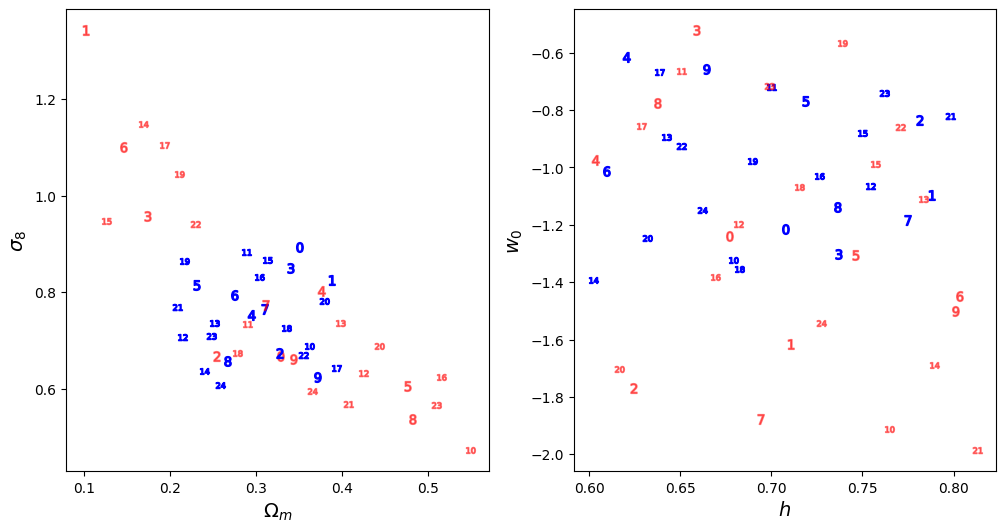

In [3]:
marker = np.arange(0, 25, 1)
fig, axs = plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1,2,1)
for i in range(len(lh_df_new)):
        axs[0].scatter(lh_df_new["Om"][i], lh_df_new["sig8"][i], color='blue', marker=f"${marker[i]}$", s=50)
        axs[0].scatter(lh_df["Om"][i], lh_df["sig8"][i], color='red', s=50, marker=f"${marker[i]}$", alpha=0.5)
        axs[1].scatter(lh_df_new["h"][i], lh_df_new["w0"][i], color='blue', marker=f"${marker[i]}$", s=50)
        axs[1].scatter(lh_df["h"][i], lh_df["w0"][i], color='red', s=50, marker=f"${marker[i]}$", alpha=0.5)
axs[0].set_xlabel(r"$\Omega_m$", fontsize=14)
axs[0].set_ylabel(r"$\sigma_8$", fontsize=14)
axs[1].set_xlabel(r"$h$", fontsize=14)
axs[1].set_ylabel(r"$w_0$", fontsize=14)

       
    

In [4]:
import distinctipy

num_colors = 25
distinct_colours = distinctipy.get_colors(num_colors, pastel_factor=0.7)

# 2. Choose a darkening factor (e.g., 0.8 for 20% darker)
darkening_factor = 0.8

# 3. Scale each color’s RGB channels
dark_colours = [
    (r * darkening_factor, g * darkening_factor, b * darkening_factor)
    for r, g, b in distinct_colours
]

# plt.scatter(np.linspace(0, 1, len(distinct_colours)), np.zeros(len(distinct_colours)), c=distinct_colours, s=100)
# # 4. Plot to verify
# plt.figure(figsize=(8, 2))
# plt.scatter(
#     np.linspace(0, 1, num_colors),
#     np.zeros(num_colors),
#     c=dark_colours,
#     s=100
# )
# plt.yticks([])
# plt.xlim(-0.05, 1.05)
# plt.title("Slightly Darkened Palette")
# plt.show()

In [5]:
results_fin = {}

In [20]:
def get_results(cosmo_index,tomo_bin, edges, centers, snr,theta1,R_pixels, filter_type,nz_file, simulation):
    results={}
    # --- Simulation block ---
    print(f"\n Processing cosmology index: {cosmo_index}")
    if simulation:
        sim_l1_runs, sim_pdf_runs, avg_sim_l1, std_sim_l1, avg_sim_pdf, std_sim_pdf, simvar = \
            get_simulation_l1(
                cosmo_index,
                tomo_bin,
                edges,
                centers,
                snr,
                R_pixels=R_pixels,
                filter_type=filter_type,
                plot=False,
            )
    else:
        sim_l1_runs = sim_pdf_runs = avg_sim_l1 = std_sim_l1 = avg_sim_pdf = std_sim_pdf = simvar = None
        
    if simulation:
        # --- Cosmology parameters ---
        h = lh_df['h'].iloc[cosmo_index]
        Oc = lh_df['Oc'].iloc[cosmo_index]
        Ob = 0.043
        w = lh_df['w0'].iloc[cosmo_index]
        wa = 0.0
        sigma8 = lh_df['sig8'].iloc[cosmo_index]
        Om = lh_df['Om'].iloc[cosmo_index]
    else:
        # --- Cosmology parameters ---
        h = lh_df_new['h'].iloc[cosmo_index]
        Om = lh_df_new['Om'].iloc[cosmo_index]
        Ob = 0.043
        Oc = Om - Ob #lh_df_new['Oc'].iloc[cosmo_index]
    
        w = lh_df_new['w0'].iloc[cosmo_index]
        wa = 0.0
        sigma8 = lh_df_new['sig8'].iloc[cosmo_index]
    

    variables = InitialiseVariables(
        h=h, Oc=Oc, Ob=Ob, w=w, wa=wa, sigma8=sigma8,
        dk=0.005, kmin=1e-4, kmax=1,
        nz_file=nz_file, variability=False,
        theta1=theta1, nplanes=8
    )

    # Compute sigma^2 maps
    variance = Variance(variables.cosmo, filter_type=filter_type, pk=variables.cosmo.pnl)
    variables.sigmasq_map = np.sum(
        variables.dchi * (variables.lensingweights ** 2) * np.array([
            variance.get_sig_slice(z, chi * variables.theta1_radian, chi * variables.theta2_radian)
            for z, chi in zip(variables.redshifts, variables.chis)
        ])
    )

    # Theory (perturbation) sigma^2
    theory_sigmasq = compute_sigma_kappa_squared(
        theta1, variables.chis, variables.lensingweights,
        variables.redshifts, variables.cosmo.k, variables.cosmo.pnl,
        filter_type=filter_type, h=h
    )
    
    variables.recal_value = variables.sigmasq_map / theory_sigmasq
        
    print(f"  The ldt variance is: {variables.sigmasq_map}")
    print(f"  The perturbation theory variance is: {theory_sigmasq}") 
    if simulation:
        print(f"   The simulation variance is: {np.mean(simvar)}")
    print(f"   The recalibration factor is: {variables.recal_value}")
            
    # Critical points and lambdas
    smallest_positive, largest_negative = find_critical_points_for_cosmo(
        variables, variance, ngrid_critical=30, plot=False, min_z=0, max_z=3
    )
    if smallest_positive and largest_negative is not None:
        variables.lambdas = np.linspace(largest_negative, smallest_positive, 20)
    else:
        variables.lambdas = np.linspace(-450, 700, 20) #tomo5
        variables.lambdas = np.linspace(-700, 800, 20) #tomo4
    if simulation and cosmo_index == 11 and tomo_bin == 5:
        variables.lambdas = np.linspace(-550, 700, 20)
    if not simulation and cosmo_index == 3 and tomo_bin==5:
        variables.lambdas = np.linspace(-500, 700, 20)
    if not simulation and cosmo_index == 4 and tomo_bin==5:
        variables.lambdas = np.linspace(-750, 800, 20)
        
    # Compute PDF and L1
    computed_PDF = computePDF(variables, variance, plot_scgf=False)
    pdf_vals, kappa_vals = computed_PDF.pdf_values, computed_PDF.kappa_values
    norm_kappa = kappa_vals / np.sqrt(theory_sigmasq)
    prediction_pdf = CubicSpline(norm_kappa, pdf_vals)(snr)
    prediction_l1 = CubicSpline(norm_kappa, np.abs(kappa_vals) * pdf_vals)(snr)

    # Store results
    pred_stats = get_moments(snr * (theory_sigmasq**0.5), prediction_pdf)            
    print(f"  predstats: mean: {pred_stats[0]}, variance: {pred_stats[1]}, s3: {pred_stats[2]:.3f}, kurtosis: {pred_stats[3]:.3f}, norm: {pred_stats[4]:.3f}")
    entry = {
        'cosmo_index': cosmo_index,
        'cosmology': {'h': h, 'Oc': Oc, 'Om': Om, 'w': w, 'wa': wa, 'sigma8': sigma8},
        'snr': snr,
        'prediction_l1': prediction_l1,
        'ldt_theory_sigma_sq': variables.sigmasq_map,
        'perturbation_theory_sigma_sq': theory_sigmasq,
        'pred_stats': {
            'mean': pred_stats[0],
            'variance': pred_stats[1],
            's3': pred_stats[2],
            'kurtosis': pred_stats[3],
            'norm': pred_stats[4]
        }        
    }
    if simulation:
        sim_stats = get_moments(snr * (np.mean(simvar)**0.5), avg_sim_pdf)
        mean_sim, variance_sim, s3_sim, kurtosis_sim, norm_sim = sim_stats
        print(f"  simstats: mean: {mean_sim}, variance: {variance_sim}, s3: {s3_sim:.3f}, kurtosis: {kurtosis_sim:.3f}, norm: {norm_sim:.3f}")
        residual = (prediction_l1 - avg_sim_l1) / avg_sim_l1
        entry.update({
            'sim_pdf_runs': sim_pdf_runs,
            'sim_l1_runs': sim_l1_runs,
            'simvar': simvar,
            'residual': residual, 
            'sim_stats': {
                'mean': mean_sim,
                'variance': variance_sim,
                's3': s3_sim,
                'kurtosis': kurtosis_sim,
                'norm': norm_sim
            }
        })
    results[cosmo_index] = entry
    return results



 Processing cosmology index: 10

Initialised Cosmology:
  h = 0.7645, Oc = 0.5009, Ob = 0.043, w = -1.9127, wa = 0.0, sigma8 = 0.4716
  k-range: [0.0001, 1] with step dk = 0.005

   Initialised Variables:
      Source redshift: from nz file
      Number of planes: 8
      Angular scale theta1 (radians): 0.001454441043328608
      Variability: disabled
Variance module initialized...
  The ldt variance is: 5.063841272765491e-06
  The perturbation theory variance is: 3.697618572411919e-06
   The simulation variance is: 6.239677217891458e-06
   The recalibration factor is: 1.3694871911740747
Finding critical points...
Setting ngrid = 30. Increase this for more accuracy, but note that computation becomes slower!
Smallest distance pair of critical points: None -1047.357404740428
The variance from PDF is:  3.6974349561215574e-06
  predstats: mean: -2.940798569830809e-08, variance: 3.6973666915247826e-06, s3: -96.106, kurtosis: 0.108, norm: 1.000
  simstats: mean: 5.697362316996971e-07, varia

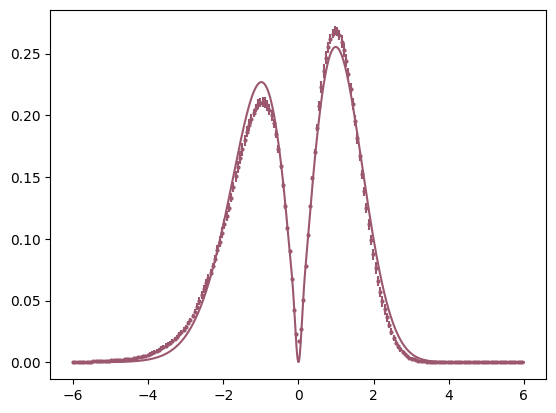

In [31]:
# --- User parameters ---
tomo_bin = 4
nz_file = f"/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/nz_arrays_bin{tomo_bin}.npy"

filter_type = 'starlet'

theta1 = 5
R_pixels = int(theta1 / 0.5)
edges = np.linspace(-0.06, 0.06, 401)
centers = 0.5 * (edges[:-1] + edges[1:])
snr = np.linspace(-6, 6, 800)

# Flag: include simulation results
simulation = True  # Set to False to disable simulation data

# Container for results
results = {}
def main():
    results = {}
    # Loop through each cosmology index
    for cosmo_index in range(10,11):
        results.update(get_results(cosmo_index, tomo_bin, edges, centers, snr, theta1, R_pixels, filter_type, nz_file, simulation=simulation))  
        plt.plot(snr, results[cosmo_index]['prediction_l1'], label=f"Cosmo {cosmo_index}", color=dark_colours[cosmo_index])
        plt.errorbar(snr[::4], np.mean(results[cosmo_index]['sim_l1_runs'], axis=0)[::4], yerr= np.std(results[cosmo_index]['sim_l1_runs'], axis=0)[::4],color=dark_colours[cosmo_index], fmt='o', markersize=2, label=f"Sim {cosmo_index}")
    return results
    
if __name__ == '__main__':
    key = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
          # or an existing dict
    results_fin[key] = main()
# np.save(key, results_fin[key], allow_pickle=True)

In [1]:
i# --- User parameters ---
tomo_bin = 4
nz_file = f"/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/nz_arrays_bin{tomo_bin}.npy"

filter_type = 'tophat'

theta1 = 5
R_pixels = int(theta1 / 0.5)
edges = np.linspace(-0.06, 0.06, 401)
centers = 0.5 * (edges[:-1] + edges[1:])
snr = np.linspace(-6, 6, 800)

# Flag: include simulation results
simulation = True  # Set to False to disable simulation data

# Container for results
results = {}
def main():
    results = {}
    # Loop through each cosmology index
    for cosmo_index in range(10,11):
        results.update(get_results(cosmo_index, tomo_bin, edges, centers, snr, theta1, R_pixels, filter_type, nz_file, simulation=simulation))  
        plt.plot(snr, results[cosmo_index]['prediction_l1'], label=f"Cosmo {cosmo_index}", color=dark_colours[cosmo_index])
        plt.errorbar(snr[::4], np.mean(results[cosmo_index]['sim_l1_runs'], axis=0)[::4], yerr= np.std(results[cosmo_index]['sim_l1_runs'], axis=0)[::4],color=dark_colours[cosmo_index], fmt='o', markersize=2, label=f"Sim {cosmo_index}")
    return results
    
if __name__ == '__main__':
    key = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
          # or an existing dict
    results_fin[key] = main()
# np.save(key, results_fin[key], allow_pickle=True)

NameError: name 'i' is not defined

Sigma: 0.00204657755914267
Sigma: 0.002631282196900048


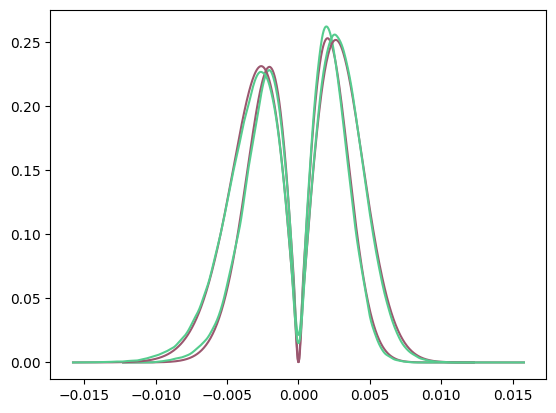

In [30]:
filter_type = 'starlet'
key_ = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
sigma = results_fin[key_][10]['ldt_theory_sigma_sq']**0.5
print(f"Sigma: {sigma}")
plt.plot(snr*sigma, results_fin[key_][10]['prediction_l1'], label=f"Cosmo {10}", color=dark_colours[10])
plt.plot(snr*sigma, results_fin[key_][10]['sim_l1_runs'].mean(axis=0), label=f"Cosmo {11}", color=dark_colours[11])
filter_type = 'tophat'
key_ = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
sigma = results_fin[key_][10]['ldt_theory_sigma_sq']**0.5
print(f"Sigma: {sigma}")
plt.plot(snr*sigma, results_fin[key_][10]['prediction_l1'], label=f"Cosmo {10}", color=dark_colours[10])
plt.plot(snr*sigma, results_fin[key_][10]['sim_l1_runs'].mean(axis=0), label=f"Cosmo {11}", color=dark_colours[11])


 Processing cosmology index: 0

Initialised Cosmology:
  h = 0.707418, Oc = 0.30714400000000003, Ob = 0.043, w = -1.216086, wa = 0.0, sigma8 = 0.8927
  k-range: [0.0001, 1] with step dk = 0.005

   Initialised Variables:
      Source redshift: from nz file
      Number of planes: 8
      Angular scale theta1 (radians): 0.004363323129985824
      Variability: disabled
Variance module initialized...
  The ldt variance is: 1.3415883545817238e-05
  The perturbation theory variance is: 1.2235389212056817e-05
   The recalibration factor is: 1.0964819600995737
Finding critical points...
Setting ngrid = 30. Increase this for more accuracy, but note that computation becomes slower!
Smallest distance pair of critical points: 863.417394753593 -372.04216672557277
The variance from PDF is:  1.2237324699837191e-05
  predstats: mean: 1.382384800547188e-07, variance: 1.2236699079997095e-05, s3: -50.713, kurtosis: 0.174, norm: 1.000

 Processing cosmology index: 1

Initialised Cosmology:
  h = 0.78780

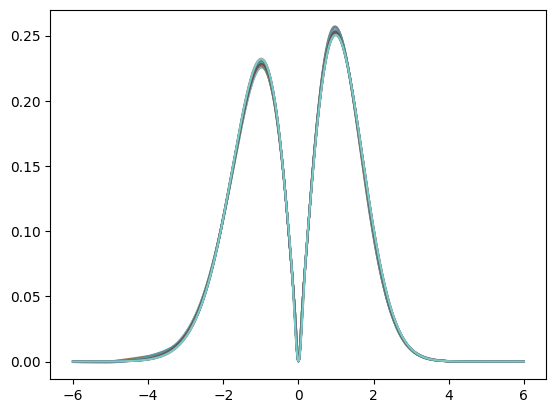

In [9]:
# --- User parameters ---
tomo_bin = 4
nz_file = f"/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/nz_arrays_bin{tomo_bin}.npy"

filter_type = 'tophat'

theta1 = 15
R_pixels = int(theta1 / 0.5)
edges = np.linspace(-0.06, 0.06, 401)
centers = 0.5 * (edges[:-1] + edges[1:])
snr = np.linspace(-6, 6, 800)

# Flag: include simulation results
simulation = False  # Set to False to disable simulation data

# Container for results
results = {}
def main():
    results = {}
    # Loop through each cosmology index
    for cosmo_index in range(0,25):
        results.update(get_results(cosmo_index, tomo_bin, edges, centers, snr, theta1, R_pixels, filter_type, nz_file, simulation=simulation))  
        plt.plot(snr, results[cosmo_index]['prediction_l1'], label=f"Cosmo {cosmo_index}", color=dark_colours[cosmo_index])
        if simulation:
            plt.errorbar(snr[::4], np.mean(results[cosmo_index]['sim_l1_runs'], axis=0)[::4], yerr= np.std(results[cosmo_index]['sim_l1_runs'], axis=0)[::4],color=dark_colours[cosmo_index], fmt='o', markersize=2, label=f"Sim {cosmo_index}")
    return results
    
if __name__ == '__main__':
    key = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
          # or an existing dict
    results_fin[key] = main()

# np.save(key, results_fin[key], allow_pickle=True)

In [10]:
np.save(key, results_fin[key], allow_pickle=True)


 Processing cosmology index: 0

Initialised Cosmology:
  h = 0.6766, Oc = 0.2809, Ob = 0.043, w = -1.2376, wa = 0.0, sigma8 = 0.6677
  k-range: [0.0001, 1] with step dk = 0.005

   Initialised Variables:
      Source redshift: from nz file
      Number of planes: 8
      Angular scale theta1 (radians): 0.004363323129985824
      Variability: disabled
Variance module initialized...
  The ldt variance is: 6.249907471790994e-06
  The perturbation theory variance is: 5.407408213689186e-06
   The simulation variance is: 6.1783412595142714e-06
   The recalibration factor is: 1.1558046340886508
Finding critical points...
Setting ngrid = 30. Increase this for more accuracy, but note that computation becomes slower!
Smallest distance pair of critical points: None -1559.1872054722362
The variance from PDF is:  5.407408195864228e-06
  predstats: mean: 6.216777365250156e-10, variance: 5.407399403129932e-06, s3: -46.224, kurtosis: 0.039, norm: 1.000
  simstats: mean: -3.547060916948147e-08, varian

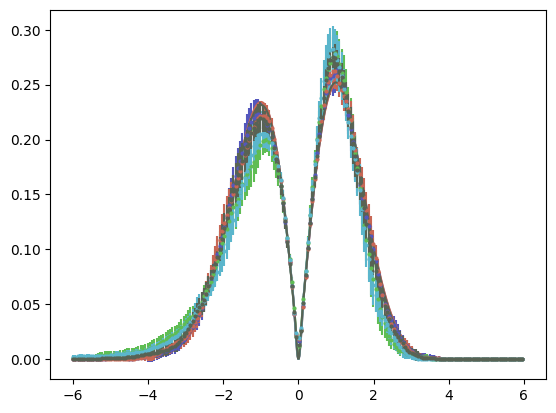

In [36]:
# --- User parameters ---
tomo_bin = 5
nz_file = f"/feynman/work/dap/lcs/vt272285/final_codes/LDT_2cell_l1_norm/data/nz_arrays_bin{tomo_bin}.npy"

filter_type = 'starlet'

theta1 = 15
R_pixels = int(theta1 / 0.5)
edges = np.linspace(-0.06, 0.06, 401)
centers = 0.5 * (edges[:-1] + edges[1:])
snr = np.linspace(-6, 6, 800)

# Flag: include simulation results
simulation = True  # Set to False to disable simulation data

# Container for results
results = {}
def main():
    results = {}
    # Loop through each cosmology index
    for cosmo_index in range(0,5):
        results.update(get_results(cosmo_index, tomo_bin, edges, centers, snr, theta1, R_pixels, filter_type, nz_file, simulation=simulation))  
        plt.plot(snr, results[cosmo_index]['prediction_l1'], label=f"Cosmo {cosmo_index}", color=dark_colours[cosmo_index])
        plt.errorbar(snr[::4], np.mean(results[cosmo_index]['sim_l1_runs'], axis=0)[::4], yerr= np.std(results[cosmo_index]['sim_l1_runs'], axis=0)[::4],color=dark_colours[cosmo_index], fmt='o', markersize=2, label=f"Sim {cosmo_index}")
    return results
    
if __name__ == '__main__':
    key = f"filter{filter_type}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
          # or an existing dict
    results_fin[key] = main()
# np.save(key, results_fin[key], allow_pickle=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


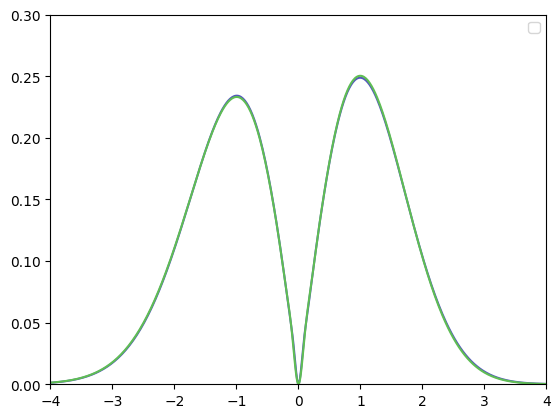

In [57]:
for i in range(0,1):
    simulation=True
    key = f"filter{'tophat'}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
    plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['prediction_l1'], color=dark_colours[i])
    # plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['sim_l1_runs'].T, color=dark_colours[i], linestyle='--', alpha=0.5)
    # plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['residual'], color=dark_colours[i], linestyle=':', alpha=0.5, label='tophat')
    plt.ylim(-0.2,0.5)
    plt.xlim(-4, 4)
    key = f"filter{'starlet'}_results_{theta1}_tomobin{tomo_bin}_simulation{simulation}"
    plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['prediction_l1'],  color=dark_colours[i+1])
    # plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['sim_l1_runs'].T,color=dark_colours[i+1], linestyle='--', alpha=0.5)
    # plt.plot(results_fin[key][i]['snr'], results_fin[key][i]['residual'], color=dark_colours[i+1], linestyle=':', alpha=0.5, label='starlet')
    plt.legend()
    plt.ylim(-0.,0.3)
    # plt.xlim(-4, 4)

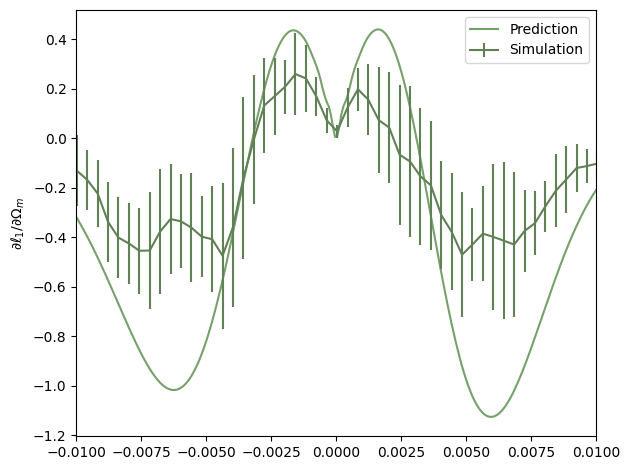

In [ ]:
def finite_difference_derivative(results,
                                 idx_minus,      # index for x-h
                                 idx_central,    # index for x
                                 idx_plus,       # index for x+h
                                 param_name,
                                 pred_field='prediction_l1',
                                 sim_field='sim_l1_runs'):
    # parameter values at minus, central, plus
    p_minus = results[idx_minus]['cosmology'][param_name]
    p_plus  = results[idx_plus]['cosmology'][param_name]
    p_central = results[idx_central]['cosmology'][param_name]
    # total parameter step (2h if symmetric around central)
    delta_param = p_plus - p_minus

    # theory derivative: (f(x+h) - f(x-h)) / delta_param
    f_plus  = results[idx_plus][pred_field]
    f_minus = results[idx_minus][pred_field]
    f_central = results[idx_central][pred_field]
    # deriv_pred = (f_plus - f_minus) #/ delta_param
    # deriv_pred_frwd = (f_plus - f_central) #/ (p_plus - p_central)
  
    snr = results[idx_central]['snr']
    # simulation-based derivative (array of runs)
    s_plus  = results[idx_plus][sim_field]
    s_minus = results[idx_minus][sim_field]
    s_central = results[idx_central][sim_field]
    kappa = np.linspace(-0.02, 0.02, 500)
    sim_plus = []
    sim_minus = []
    sim_central = []
    for i in range(len(s_plus)):
        sigplus = results[idx_plus]['simvar'][i]**0.5
        sigminus = results[idx_minus]['simvar'][i]**0.5
        sigcentral = results[idx_central]['simvar'][i]**0.5
        splus_spline = CubicSpline(snr*sigplus, s_plus[i])
        sminus_spline = CubicSpline(snr*sigminus, s_minus[i])
        scentral_spline = CubicSpline(snr*sigcentral, s_central[i])
        sim_plus.append(splus_spline(kappa))
        sim_minus.append(sminus_spline(kappa))
        sim_central.append(scentral_spline(kappa))
    sim_plus = np.array(sim_plus)
    sim_minus = np.array(sim_minus)
    sim_central = np.array(sim_central)
    
    fplus_spline = CubicSpline(snr*(np.mean(results[idx_plus]['simvar'])**0.5), f_plus) 
    fminus_spline = CubicSpline(snr*(np.mean(results[idx_minus]['simvar'])**0.5), f_minus)
    fcentral_spline = CubicSpline(snr*(np.mean(results[idx_central]['simvar'])**0.5), f_central)
    fplus = fplus_spline(kappa)
    fminus = fminus_spline(kappa)
    fcentral = fcentral_spline(kappa)
     
    deriv_sim = (sim_plus - sim_minus) / delta_param
    deriv_pred = (fplus - fminus) / delta_param
    # deriv_sim_central = (sim_plus - sim_central) #/ (p_plus - p_central)
    

    # keep SNR from the central point
    
    snr = snr*(np.mean(results[idx_central]['simvar'])**0.5)
    
    # plt.plot(kappa, fplus, c=distinct_colours[5], label='f_plus')
    # plt.plot(kappa, sim_plus.T, c=dark_colours[5], label='s_plus')
    # plt.plot(snr, f_minus, c=distinct_colours[6], label='f_minus')
    # plt.plot(snr, s_minus.T, c=dark_colours[6], label='s_minus')
    plt.plot(kappa, deriv_pred, c=distinct_colours[7], label='Prediction')
    plt.errorbar(kappa[::5], np.mean(deriv_sim, axis=0)[::5],yerr=np.std(deriv_sim, axis=0)[::5], c=dark_colours[7], label='Simulation')
    # plt.plot(snr, deriv_pred_frwd, c=distinct_colours[8], label='deriv_pred_frwd')
    # plt.plot(snr, deriv_sim_central.T, c=dark_colours[8], label='deriv_sim_central')
    
    return snr, deriv_pred, deriv_sim

# # compute derivatives
# snr, deriv_pred, deriv_sim = finite_difference_derivative(
#     tophat_results, 0, 9, 24, 'Om',
#     pred_field='prediction_l1',
#     sim_field='sim_l1_runs'
# )

# # plot
# # plt.plot(
# #     snr,
# #     deriv_pred,
# #     c=distinct_colours[5],
# #     label=r"Theory $\partial \ell_1 / \partial \Omega_m$",
# #     linewidth=2
# # )
# # # plt.plot(snr, deriv_sim,c=dark_colours[5], label='Simulation Derivative', linewidth=2)

# # plt.errorbar(
# #     snr[::4],
# #     deriv_sim.mean(axis=0)[::4],
# #     yerr=deriv_sim.std(axis=0)[::4],
# #     c=dark_colours[5],
# #     label='Simulation Derivative',
# #     linewidth=2
# # )

# plt.legend()
# plt.xlim(-0.01, 0.01)
# # plt.xlabel('SNR')
# plt.ylabel(r'$\partial \ell_1 / \partial \Omega_m$')
# plt.tight_layout()
# plt.show()



In [ ]:


# lh_df_new


Initialised Cosmology:
  h = 0.707418, Oc = 0.30714400000000003, Ob = 0.043, w = -1.216086, wa = 0.0, sigma8 = 0.8927
  k-range: [0.0001, 1.2] with step dk = 0.005

   Initialised Variables:
      Source redshift: from nz file
      Number of planes: 7
      Angular scale theta1 (radians): 0.004363323129985824
      Variability: disabled
Variance module initialized...
The ldt variance is: 2.6891688705838914e-05
The perturbation theory variance is: 2.518955541437684e-05
The recalibration factor is: 1.0675729786993615
Finding critical points...
Setting ngrid = 40. Increase this for more accuracy, but note that computation becomes slower!
Smallest distance pair of critical points: 814.8281418763258 -407.00882300682855
The variance from PDF is:  2.518954939350537e-05
predstats: mean: 7.692112860731293e-09, variance: 2.5189316127260283e-05, s3: -27.100, kurtosis: 0.099, norm: 1.000

Initialised Cosmology:
  h = 0.787803, Oc = 0.344051, Ob = 0.043, w = -1.096119, wa = 0.0, sigma8 = 0.824871

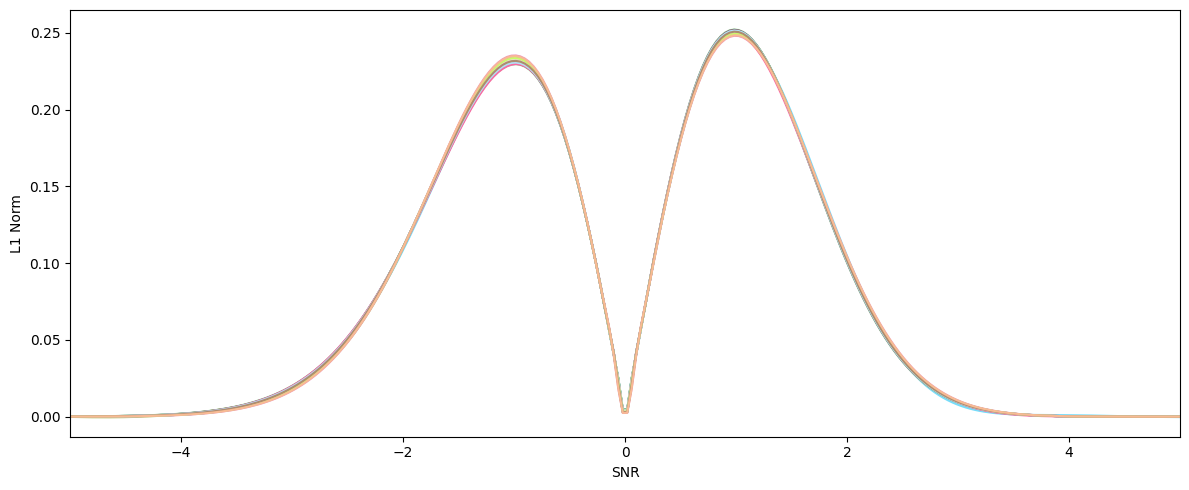

In [6]:
def plot_results(result, simulation=True):
    values = result
    snr = values[:]['snr']
    prediction_l1 = values[:]['prediction_l1']
    
    if simulation:
        simulation_l1 = values[:]['sim_l1_runs']
        snr = snr * (np.mean(values[:]['simvar'])**0.5)
        plt.errorbar(snr[::3], simulation_l1.mean(axis=0)[::3], yerr=np.std(simulation_l1,axis=0), label='Simulation L1 Norm', c='red')
        plt.plot(snr, prediction_l1, label='Computed L1 Norm', c='blue')
    
    
plot_results(results["filtertophat_results_theta115_tomobin5_simulationTrue"])
plot_results(ns.filter_results_theta115_tomobin5_simulationFalse, simulation=False)

KeyError: 'filtertophat_results_theta115_tomobin5_simulationTrue'

In [80]:
print(ns.__dict__)  

{"<class 'filter'>_results_theta115_tomobin5_simulationTrue": {0: {'cosmo_index': 0, 'cosmology': {'h': 0.6766, 'Oc': 0.2809, 'Om': 0.3282, 'w': -1.2376, 'wa': 0.0, 'sigma8': 0.6677}, 'snr': array([-6.        , -5.95986622, -5.91973244, -5.87959866, -5.83946488,
       -5.7993311 , -5.75919732, -5.71906355, -5.67892977, -5.63879599,
       -5.59866221, -5.55852843, -5.51839465, -5.47826087, -5.43812709,
       -5.39799331, -5.35785953, -5.31772575, -5.27759197, -5.23745819,
       -5.19732441, -5.15719064, -5.11705686, -5.07692308, -5.0367893 ,
       -4.99665552, -4.95652174, -4.91638796, -4.87625418, -4.8361204 ,
       -4.79598662, -4.75585284, -4.71571906, -4.67558528, -4.63545151,
       -4.59531773, -4.55518395, -4.51505017, -4.47491639, -4.43478261,
       -4.39464883, -4.35451505, -4.31438127, -4.27424749, -4.23411371,
       -4.19397993, -4.15384615, -4.11371237, -4.0735786 , -4.03344482,
       -3.99331104, -3.95317726, -3.91304348, -3.8729097 , -3.83277592,
       -3.7926421